In [7]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

from pyspark.sql import SparkSession, functions as F, types as T
from delta import configure_spark_with_delta_pip

builder = (SparkSession.builder.appName("delta_ridehailing")
           .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
           .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog"))
spark = configure_spark_with_delta_pip(builder).getOrCreate()
# ---------- Inline data ----------
trip_schema = T.StructType([
T.StructField("trip_id", T.IntegerType()),
T.StructField("rider_id", T.StringType()),
T.StructField("driver_id", T.StringType()),
T.StructField("city", T.StringType()),
T.StructField("distance_km", T.DoubleType()),
T.StructField("fare", T.DoubleType()),
T.StructField("tip", T.DoubleType()),
T.StructField("ts", T.StringType())
])
driver_schema = T.StructType([
T.StructField("driver_id", T.StringType()),
T.StructField("driver_name",T.StringType()),
T.StructField("rating", T.DoubleType()),
T.StructField("vehicle", T.StringType())
])
trips_rows = trips_rows = [
    (1001,"R001","D010","Bengaluru",12.4,320.0,20.0,"2025-08-08 08:05:00"),
    (1002,"R002","D011","Hyderabad",6.2,150.0,10.0,"2025-08-08 08:15:00"),
    (1003,"R003","D012","Pune",3.5,90.0,0.0,"2025-08-08 08:20:00"),
    (1004,"R001","D010","Bengaluru",18.9,480.0,25.0,"2025-08-08 08:45:00"),
    (1005,"R004","D013","Chennai",10.0,260.0,15.0,"2025-08-08 09:05:00"),
    (1006,"R005","D012","Pune",2.2,70.0,0.0,"2025-08-08 09:10:00")
]
drivers_rows = [
("D010","Anil", 4.8,"WagonR"),
("D011","Sana", 4.6,"i20"),
("D012","Rakesh", 4.4,"Swift"),
("D013","Meera", 4.9,"Ciaz")
]
trips_df = spark.createDataFrame(trips_rows, schema=trip_schema).withColumn("ts", F.to_timestamp("ts"))
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)
# Save as Delta (fresh paths)
BASE = "/tmp/delta/ride_hailing" # Databricks & Colab local FS compatible
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"
trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)
print("Seeded:")
print(" Trips ->", TRIPS_PATH)
print(" Drivers->", DRIVERS_PATH)

Seeded:
 Trips -> /tmp/delta/ride_hailing/trips
 Drivers-> /tmp/delta/ride_hailing/drivers


In [8]:
trips_df.show()
drivers_df.show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D010|       Anil|   4.8| WagonR|
|     D011|       Sana|

#1) Managed vs Unmanaged Tables

In [13]:
# Create a managed Delta table trips_managed by AS SELECT from the Delta path.
trips_df.write.format("delta").mode("overwrite").saveAsTable("trips_managed")
spark.sql(f"create table if not exists trips_managed using delta location '{TRIPS_PATH}' as select * from delta.`{TRIPS_PATH}`")
# Create an external (unmanaged) table drivers_ext that points to DRIVERS_PATH .
spark.sql(f"create table if not exists drivers_ext using delta location '{DRIVERS_PATH}'")
# Verify locations with DESCRIBE DETAIL and explain the difference in your own words.
spark.sql("describe detail trips_managed").show()
spark.sql("describe detail drivers_ext").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|0d4cd752-53c8-403...|spark_catalog.def...|       NULL|file:/content/spa...|2025-08-14 05:58:...|2025-08-14 05:58:...|              []|       2|       4536|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+------------------

In [18]:
location = spark.sql('describe detail trips_managed').collect()[0]['location']
print("trips_managed location: ",location)
print("In managed, Data is stored in the warehouse folder. Dropping the table also deletes the data.\n")
location2 = spark.sql('describe detail drivers_ext').collect()[0]['location']
print("drivers_ext location: ",location2)
print("In unmanaged, Data is stored wherever I specified (external path). Dropping the table does NOT delete the data.")

trips_managed location:  file:/content/spark-warehouse/trips_managed
In managed, Data is stored in the warehouse folder. Dropping the table also deletes the data.

drivers_ext location:  file:/tmp/delta/ride_hailing/drivers
In unmanaged, Data is stored wherever I specified (external path). Dropping the table does NOT delete the data.


#2) Read & Explore

In [20]:
# Read both tables, print schemas, and show 10 rows.
trips_df = spark.read.format("delta").load(TRIPS_PATH)
drivers_df = spark.read.format("delta").load(DRIVERS_PATH)
print("Trips Schema:")
trips_df.printSchema()
print("Drivers Schema:")
drivers_df.printSchema()
print("Trips:")
trips_df.show(10)
print("Drivers:")
drivers_df.show(10)

Trips Schema:
root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

Drivers Schema:
root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

Trips:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 

In [21]:
# Compute a derived column total_amount = fare + tip and show top 5 trips by total_amount .
trips_df = trips_df.withColumn("total_amount", F.col("fare") + F.col("tip"))
trips_df.orderBy(F.col("total_amount").desc()).show(5)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|       505.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|       275.0|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|       160.0|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|        90.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows



#3) Update (Business Rule)

In [34]:
# Increase tip by 5 for trips in Bengaluru where distance_km > 15 .
trips_df=trips_df.withColumn("tip", F.when((F.col("city")=="Bengaluru") & (F.col("distance_km")>15),F.col("tip")+5).otherwise(F.col("tip")))

In [32]:
# Show before/after for affected rows only.
print("before: ")
trips_df.filter((F.col("city") == "Bengaluru") & (F.col("distance_km") > 15)).show()
print("after: ")
trips_df.filter((F.col("city") == "Bengaluru") & (F.col("distance_km") > 15)).withColumn("tip", F.col("tip") + 5).show()

before: 
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|       505.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+

after: 
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|       505.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+



#4) Delete (Data Quality)

In [25]:
# Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).
trips_df.filter((F.col("fare") <= 0) | (F.col("distance_km") <= 0)).show()

+-------+--------+---------+----+-----------+----+---+---+------------+
|trip_id|rider_id|driver_id|city|distance_km|fare|tip| ts|total_amount|
+-------+--------+---------+----+-----------+----+---+---+------------+
+-------+--------+---------+----+-----------+----+---+---+------------+



In [26]:
# Show remaining row count.
trips_df.filter((F.col("fare") > 0) & (F.col("distance_km") > 0)).count()

6

#5) Merge (Upsert New Batch)

In [43]:
# Create a new inline batch with:
# one existing trip_id (e.g., 1004) but a corrected fare or tip, and one new trip (e.g., 1007).
new_trips_rows = [
    (1004,"R001","D010","Bengaluru",18.9,500.0,25.0, "2025-08-08 08:45:00"), # updated fare
    (1007,"R006","D011","Hyderabad",5.5,140.0,12.0, "2025-08-09 07:35:00")   # new trip
]
new_trips_df = spark.createDataFrame(new_trips_rows, schema=trip_schema).withColumn("ts", F.to_timestamp("ts"))

In [45]:
# Perform a MERGE (match on trip_id ) to update the existing and insert the new.
from delta.tables import DeltaTable
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
delta_trips.alias("old").merge(
    new_trips_df.alias("new"),
    "old.trip_id = new.trip_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()


In [46]:
# Show rows for trip_id IN (1004,1007) to confirm.
delta_trips.toDF().filter(F.col("trip_id").isin([1004,1007])).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|25.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        5.5|140.0|12.0|2025-08-09 07:35:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#6) Gold View (Join & KPIs)
Join trips with drivers on driver_id .
Create a gold view with columns: trip_id, city, driver_name, rating,distance_km, total_amount, ts .


In [47]:
from pyspark.sql import functions as f
trips = spark.read.format("delta").load(TRIPS_PATH)
drivers = spark.read.format("delta").load(DRIVERS_PATH)

# join and compute total_amount
gold_df = trips.alias("t").join( drivers.alias("d"), trips.driver_id == drivers.driver_id,"left").select(
    f.col("t.trip_id"),
    f.col("t.city"),
    f.col("d.driver_name"),
    f.col("d.rating"),
    f.col("t.distance_km"),
    (f.col("t.fare") + f.col("t.tip")).alias("total_amount"),
    f.col("t.ts")
)

# create a temp view
gold_df.createOrReplaceTempView("gold_view")


##From this gold view:
* Compute city-wise total revenue and average driver rating.
* Compute driver-wise total trips and top 3 drivers by revenue.

In [57]:
spark.sql("select city, sum(total_amount) as total_revenue, round(avg(rating),2) as avg_driver_rating from gold_view group by city").show()

+---------+-------------+-----------------+
|     city|total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|  Chennai|        275.0|              4.9|
|     Pune|        160.0|              4.4|
|Bengaluru|        865.0|              4.8|
|Hyderabad|        312.0|              4.6|
|   Mumbai|        345.0|              4.5|
+---------+-------------+-----------------+



as per task 9 the above code is rerunned and the changes are observed

In [49]:
spark.sql("select driver_name,count(trip_id) as total_trips,sum(total_amount) as total_revenue from gold_view group by driver_name order by total_revenue desc limit 3").show()


+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        865.0|
|       Sana|          2|        312.0|
|      Meera|          1|        275.0|
+-----------+-----------+-------------+



#7) Time Travel & History

In [50]:
# Show DESCRIBE HISTORY for the trips table (the one you updated/merged).
spark.sql("describe history trips_managed").show()

+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2025-08-14 05:58:...|  NULL|    NULL|CREATE OR REPLACE...|{isManaged -> tru...|NULL|    NULL|     NULL|       NULL|  Serializable|        false|{numFiles -> 2, n...|        NULL|Apache-Spark/3.5....|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+-----------

In [52]:
# Read the table as of version 0, and compare counts and a few rows with the latest version.
trips_df_v0 = spark.read.format("delta").option("versionAsOf", 0).load(TRIPS_PATH)
trips_df_latest = spark.read.format("delta").load(TRIPS_PATH)
print("trips_df_v0 count: ",trips_df_v0.count())
print("trips_df_latest count: ",trips_df_latest.count())
trips_df_v0.show(5)
trips_df_latest.show(5)

trips_df_v0 count:  6
trips_df_latest count:  7
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
only showing top 5 rows

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+-------

#8) Partitioned Rewrite (Performance)

In [53]:
# Rewrite the trips table partitioned by city into a new Delta path.
trips_df.write.format("delta").partitionBy("city").mode("overwrite").save(f"{BASE}/trips_partitioned")

In [54]:
# Compare file layout (optional: list files) and run a simple filter city='Bengaluru' to observe read behavior/time.
partitioned_trips = spark.read.format("delta").load(f"{BASE}/trips_partitioned")
# filter Bengaluru trips
partitioned_trips.filter("city='Bengaluru'").show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|       525.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+



#9) Incremental Load Simulation

In [55]:
# Create a small incremental batch (e.g., trip_ids 1008–1009) with a new city (e.g., Mumbai).

incremental_rows = [
    (1008,"R007","D011","Mumbai",7.0,180.0,15.0, "2025-08-08 11:00:00"),
    (1009,"R008","D012","Mumbai",5.5,140.0,10.0, "2025-08-08 11:30:00")
]

incremental_df = spark.createDataFrame(incremental_rows, schema=trip_schema).withColumn("ts", f.to_timestamp("ts"))

In [56]:
# Append to the trips table.
incremental_df.write.format("delta").mode("append").save(TRIPS_PATH)

In [ ]:
# Re-run the city-wise revenue aggregation and note the change.
# Done

#10) Simple Streaming (File Stream → Console)

In [ ]:
# Start a structured stream that reads Delta from TRIPS_PATH in readStream mode and writes to console (append).
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime='5 seconds').start()
query.awaitTermination()

In [ ]:
# While the stream runs, append another tiny batch (e.g., one more Mumbai trip) and observe the new row displayed.
new_batch_rows = [(1010,"R009","D013","Mumbai",6.0,150.0,12.0,"2025-08-08 12:00:00")]
new_batch_df = spark.createDataFrame(new_batch_rows, schema=trip_schema).withColumn("ts", f.to_timestamp("ts"))
new_batch_df.write.format("delta").mode("append").save(TRIPS_PATH)

It is not possible to run two cells at a time in colab so while streaming i am unable to run a new cell to append and see output.


#11) Visualization

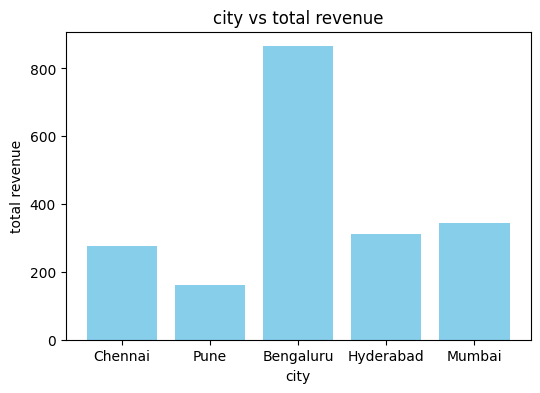

In [92]:
# Convert the gold view results (city revenue) to Pandas and plot a bar chart of city vs total revenue.
import matplotlib.pyplot as plt
import pandas as pd
gold_df = trips.alias("t").join(drivers.alias("d"), "driver_id").select(
        "t.trip_id",
        "t.city",
        "d.driver_name",
        "d.rating",
        "t.distance_km",
        (f.col("t.fare")+f.col("t.tip")).alias("total_amount"),
        "t.ts"
    )
city_rev = gold_df.groupBy("city").sum("total_amount").toPandas()
city_rev.columns = ["city","total_revenue"]
plt.figure(figsize=(6,4))
plt.bar(city_rev["city"], city_rev["total_revenue"], color="skyblue")
plt.xlabel("city")
plt.ylabel("total revenue")
plt.title("city vs total revenue")
plt.show()

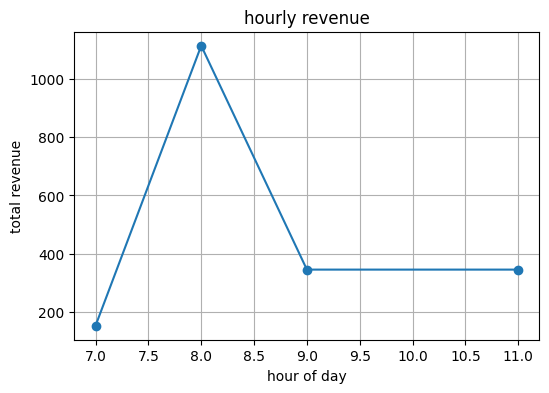

In [93]:
# Plot a line chart of hourly revenue: group by hour(ts) and sum total_amount .
gold_df = gold_df.withColumn("hour", f.hour("ts"))
hourly_rev = gold_df.groupBy("hour").sum("total_amount").orderBy("hour").toPandas()
hourly_rev.columns = ["hour","total_revenue"]
plt.figure(figsize=(6,4))
plt.plot(hourly_rev["hour"], hourly_rev["total_revenue"], marker="o")
plt.xlabel("hour of day")
plt.ylabel("total revenue")
plt.title("hourly revenue")
plt.grid(True)
plt.show()

#12) Managed vs Unmanaged Cleanup

In [94]:
# DROP TABLE the managed and unmanaged tables; verify:
# Data for managed is removed with the table (when stored in the warehouse).
# Data for unmanaged stays at DRIVERS_PATH after drop.
spark.sql("drop table if exists trips_managed")
spark.sql("drop table if exists drivers_ext")

DataFrame[]

#13) Constraint/Quality Check (Optional)

In [108]:
# Add a check to reject rows where tip < 0 (enforce during write or simulate with a filter before save).
# Demonstrate an attempt to write bad data and show how you prevented it.
from pyspark.sql import functions as f
bad_rows = [(1011,"R010","D011","Chennai",5.0,120.0,-10.0,"2025-08-08 13:00:00"),(1012,"R012","D012","Chennai",3.0,300.0,20.0,"2025-08-08 12:00:00")]
bad_df = spark.createDataFrame(bad_rows, schema=trip_schema).withColumn("ts", f.to_timestamp("ts"))
bad_df.show()

+-------+--------+---------+-------+-----------+-----+-----+-------------------+
|trip_id|rider_id|driver_id|   city|distance_km| fare|  tip|                 ts|
+-------+--------+---------+-------+-----------+-----+-----+-------------------+
|   1011|    R010|     D011|Chennai|        5.0|120.0|-10.0|2025-08-08 13:00:00|
|   1012|    R012|     D012|Chennai|        3.0|300.0| 20.0|2025-08-08 12:00:00|
+-------+--------+---------+-------+-----------+-----+-----+-------------------+



In [109]:
valid_df = bad_df.filter(f.col("tip") >= 0)
valid_df.show()

+-------+--------+---------+-------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|   city|distance_km| fare| tip|                 ts|
+-------+--------+---------+-------+-----------+-----+----+-------------------+
|   1012|    R012|     D012|Chennai|        3.0|300.0|20.0|2025-08-08 12:00:00|
+-------+--------+---------+-------+-----------+-----+----+-------------------+



In [105]:
trips_df.show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|       525.0|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|       275.0|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|        70.0|
|   1007|    R006|     D011|Hyderabad|        5.5|140.0|12.0|2025-08-09 07:35:00|       152.0|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|       340.0|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|       160.0|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|        90.0|
|   1012|    R012|     D012|  Chennai|        3.0|

14) Convert Parquet → Delta (Optional)

In [113]:
# Save a small subset of trips as Parquet in a new folder and CONVERT TO DELTA.
# took first 2 rows as a sample
parquet_path = "/tmp/delta/ride_hailing/trips_parquet"
sample_df = spark.read.format("delta").load(TRIPS_PATH).limit(2)
sample_df.write.mode("overwrite").parquet(parquet_path)
from delta.tables import DeltaTable
DeltaTable.convertToDelta(spark, f"parquet.`{parquet_path}`")
delta_df = spark.read.format("delta").load(parquet_path)
delta_df.show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [114]:
# Show it can now accept MERGE and time travel.
from delta.tables import DeltaTable
import pyspark.sql.functions as f

# load delta table
delta_table = DeltaTable.forPath(spark, parquet_path)

# new batch: one existing trip_id (update) + one new trip_id (insert)
new_rows = [
    (1001, "R003", "D010", "Bengaluru", 12.0, 300.0, 15.0, "2025-08-08 15:00:00"),
    (1012, "R011", "D012", "Pune", 5.0, 100.0, 5.0, "2025-08-08 15:05:00")
]

new_df = spark.createDataFrame(new_rows, schema=trip_schema).withColumn("ts", f.to_timestamp("ts"))

# merge
delta_table.alias("t").merge(
    new_df.alias("s"),
    "t.trip_id = s.trip_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()
spark.read.format("delta").load(parquet_path).filter(f.col("trip_id").isin([sample_df.collect()[0]["trip_id"], 1012])).show()

+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R003|     D010|Bengaluru|       12.0|300.0|15.0|2025-08-08 15:00:00|
|   1012|    R011|     D012|     Pune|        5.0|100.0| 5.0|2025-08-08 15:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



In [117]:
# time travel. read version 0
print("latest:")
spark.read.format("delta").load(parquet_path).show()
df_v0 = spark.read.format("delta").option("versionAsOf", 0).load(parquet_path)
print("version 0:")
df_v0.show()

latest:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R003|     D010|Bengaluru|       12.0|300.0|15.0|2025-08-08 15:00:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1012|    R011|     D012|     Pune|        5.0|100.0| 5.0|2025-08-08 15:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

version 0:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:

#15) Bonus KPI Dashboard (Notebook Display)

total revenue: 2387.0


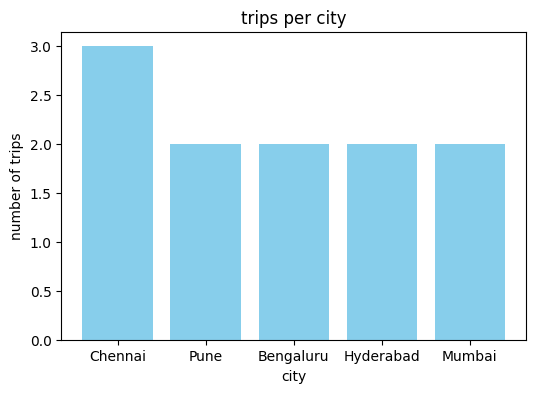

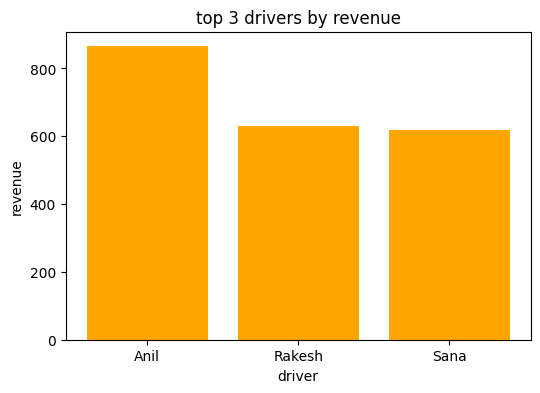

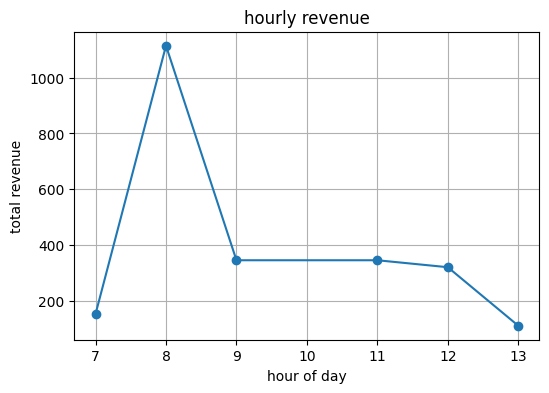

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as f

# create gold_df with ts included (if not already)
gold_df = trips.alias("t").join(drivers.alias("d"), "driver_id").select(
        "t.trip_id",
        "t.city",
        "d.driver_name",
        "d.rating",
        "t.distance_km",
        (f.col("t.fare")+f.col("t.tip")).alias("total_amount"),
        "t.ts"
    )

# total revenue
total_rev = gold_df.agg(f.sum("total_amount")).collect()[0][0]
print("total revenue:", total_rev)

# trips per city (bar chart)
city_trips = gold_df.groupBy("city").count().toPandas()
plt.figure(figsize=(6,4))
plt.bar(city_trips["city"], city_trips["count"], color="skyblue")
plt.xlabel("city")
plt.ylabel("number of trips")
plt.title("trips per city")
plt.show()

# top drivers by revenue (bar chart)
driver_rev = gold_df.groupBy("driver_name").sum("total_amount").toPandas()
driver_rev.columns = ["driver_name","revenue"]
driver_rev = driver_rev.sort_values("revenue", ascending=False).head(3)

plt.figure(figsize=(6,4))
plt.bar(driver_rev["driver_name"], driver_rev["revenue"], color="orange")
plt.xlabel("driver")
plt.ylabel("revenue")
plt.title("top 3 drivers by revenue")
plt.show()

#  revenue by hour (line chart)
gold_df = gold_df.withColumn("hour", f.hour("ts"))
hourly_rev = gold_df.groupBy("hour").sum("total_amount").orderBy("hour").toPandas()
hourly_rev.columns = ["hour","total_revenue"]

plt.figure(figsize=(6,4))
plt.plot(hourly_rev["hour"], hourly_rev["total_revenue"], marker="o")
plt.xlabel("hour of day")
plt.ylabel("total revenue")
plt.title("hourly revenue")
plt.grid(True)
plt.show()
